In [72]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from io import StringIO
import pydotplus
from IPython.display import Image

In [73]:
def plot_tree(estimator,feature_names):
    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data,feature_names=feature_names,
                   rounded=True,filled=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return Image(graph.create_png())

In [74]:
tree_data = pd.read_csv("binary_splitting_data.csv")
tree_data

,y,x1,x2
0,0.162298,0.926459,0.366176
1,9.033972,1.822821,-1.327041
2,-10.962341,-1.610567,2.412592
3,-0.940886,-0.285110,0.063815
4,-4.902579,-0.342073,1.545515


In [75]:
def oneSplit(Data, Variable, Split):
    idx = Data.iloc[:, Variable+1] < Split
    SS1 = Data[idx]
    SS2 = Data[~idx]
    mean1 = SS1["y"].mean()
    mean2 = SS2["y"].mean()
    H1 = np.sum((SS1["y"] - mean1)**2)
    H2 = np.sum((SS2["y"] - mean2)**2)
    return H1 + H2
    
def selectSplit(Data):
    X = Data.drop("y", axis=1)
    names = X.columns
    splits = np.sort(X.values, axis=0)
    for i in range(0, len(splits) - 1):
        splits[i] = (splits[i] + splits[i+1])/2
    splits = np.delete(splits, -1, axis=0)
    splits = pd.DataFrame(splits, columns=names)

    #создаем DataFrame c названиями splits%i_SS и в ячеку i j помещаем oneSplit(Data, j, splits.iloc[i:j])
    res = np.array([[oneSplit(Data, i, splits.iloc[j, i]) for i in range(len(splits.columns))] for j in range(len(splits))])
    names1 = [f"splits{i}_SS" for i in range(1, len(names)+1)]
    if len(res) > 0:
        res = pd.DataFrame(res, columns=names1)
    res = pd.DataFrame(res)
    return {"SS": res, "splits": splits}
    

In [76]:
node1 = selectSplit(tree_data)
for k,v in node1.items(): print(k,'\n',v)
    
# which variable needs split? compare minimum SS for each variable
splitVar = 2 if min(node1["SS"].splits1_SS)>=min(node1["SS"].splits2_SS) else 1
print('splitVar =', splitVar)

SS 
    splits1_SS  splits2_SS
0  103.749224   75.868220
1   78.167499  111.792670
2   90.301727   78.167499
3   75.868220  103.749224
splits 
          x1        x2
0 -0.976320 -0.631613
1 -0.313591  0.214996
2  0.320675  0.955845
3  1.374640  1.979053
splitVar = 2


In [77]:
# where is to split? row number corresponding to smallest SS
splitNum = np.argmin(node1["SS"].splits1_SS) if splitVar==1 else np.argmin(
                                                node1["SS"].splits2_SS)  
print('splitNum =', splitNum)

# what is the split level? row splitNum in column splitVar
splitLevel_1 = node1["splits"].iloc[splitNum,splitVar-1]
print('splitLevel_1 =', splitLevel_1)

splitNum = 0
splitLevel_1 = -0.6316127504975932


In [78]:
mask = tree_data.iloc[:,splitVar]>=splitLevel_1
Reg1 = tree_data[mask]
print(Reg1)
Reg2 = tree_data[~mask]
print(Reg2)

           y        x1        x2
0   0.162298  0.926459  0.366176
2 -10.962341 -1.610567  2.412592
3  -0.940886 -0.285110  0.063815
4  -4.902579 -0.342073  1.545515
          y        x1        x2
1  9.033972  1.822821 -1.327041


In [79]:
print(mask)
tree_data.iloc[:,splitVar]

0     True
1    False
2     True
3     True
4     True
Name: x2, dtype: bool


0    0.366176
1   -1.327041
2    2.412592
3    0.063815
4    1.545515
Name: x2, dtype: float64

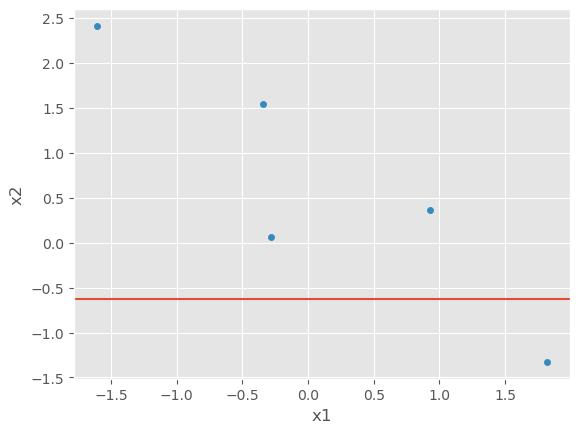

In [80]:
ax = tree_data.drop('y',axis=1).plot(x='x1',y='x2',kind='scatter')
if splitVar==1: plt.axvline(x=splitLevel_1)
else: plt.axhline(y=splitLevel_1)

In [86]:
node2 = selectSplit(Reg2)
print(node2)

{'SS': Empty DataFrame
Columns: [0]
Index: [], 'splits': Empty DataFrame
Columns: [x1, x2]
Index: []}


In [87]:
node2 = selectSplit(Reg1)
print(node2)

{'SS':    splits1_SS  splits2_SS
0   14.188337   62.043766
1   18.968864   18.968864
2   50.948426   14.188337, 'splits':          x1        x2
0 -0.976320  0.214996
1 -0.313591  0.955845
2  0.320675  1.979053}


In [88]:
splitVar = 2 if min(node2["SS"].splits1_SS)>min(node2["SS"].splits2_SS) else 1
print('splitVar =', splitVar)

splitVar = 1


In [89]:
splitNum = np.argmin(node2["SS"].splits1_SS) if splitVar==1 else np.argmin(
                                                node2["SS"].splits2_SS)  
print('splitNum =', splitNum)

splitLevel_2 = node2["splits"].iloc[splitNum,splitVar-1]
print('splitLevel_2 =', splitLevel_2)

splitNum = 0
splitLevel_2 = -0.9763199640224745


In [90]:
mask = Reg1.iloc[:,splitVar]>=splitLevel_2
Reg3 = Reg1[mask]
print(Reg3)
Reg4 = Reg1[~mask]
print(Reg4)

          y        x1        x2
0  0.162298  0.926459  0.366176
3 -0.940886 -0.285110  0.063815
4 -4.902579 -0.342073  1.545515
           y        x1        x2
2 -10.962341 -1.610567  2.412592


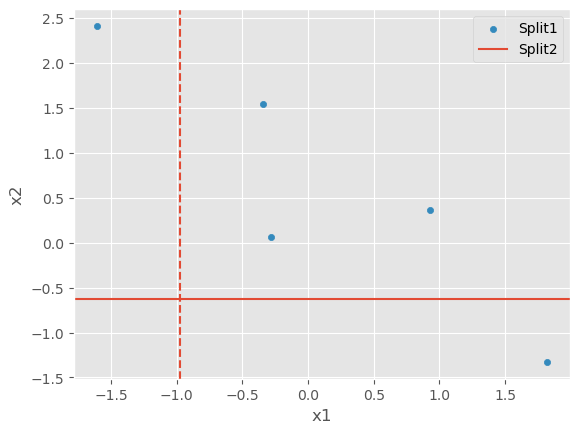

In [91]:
# using ax we continue editing the above plot
if splitVar==1:
    ax.axvline(x=splitLevel_2,linestyle='--')
else:
    ax.axhline(y=splitLevel_2,linestyle='--')
ax.legend(['Split1','Split2'],bbox_to_anchor=(1, 1))
ax.get_figure()

In [92]:
node3 = selectSplit(Reg4)
print(node3)

{'SS': Empty DataFrame
Columns: [0]
Index: [], 'splits': Empty DataFrame
Columns: [x1, x2]
Index: []}


In [93]:
node3 = selectSplit(Reg3)
for k,v in node3.items(): print(k,'\n',v)

SS 
    splits1_SS  splits2_SS
0    0.608508   12.826492
1    7.847506    0.608508
splits 
          x1        x2
0 -0.313591  0.214996
1  0.320675  0.955845


In [94]:
splitVar = 2 if min(node3["SS"].splits1_SS)>min(node3["SS"].splits2_SS) else 1
print('splitVar =', splitVar)

splitVar = 1


In [95]:
splitNum = np.argmin(node3["SS"].splits1_SS) if splitVar==1 else np.argmin(
                                                node3["SS"].splits2_SS)  
print('splitNum =', splitNum)

splitLevel_3 = node3["splits"].iloc[splitNum,splitVar-1]
print('splitLevel_3 =', splitLevel_3)

splitNum = 0
splitLevel_3 = -0.31359139097064603


In [96]:
mask = Reg3.iloc[:,splitVar]>=splitLevel_3
Reg5 = Reg3[mask]
print(Reg5)
Reg6 = Reg3[~mask]
print(Reg6)

          y        x1        x2
0  0.162298  0.926459  0.366176
3 -0.940886 -0.285110  0.063815
          y        x1        x2
4 -4.902579 -0.342073  1.545515


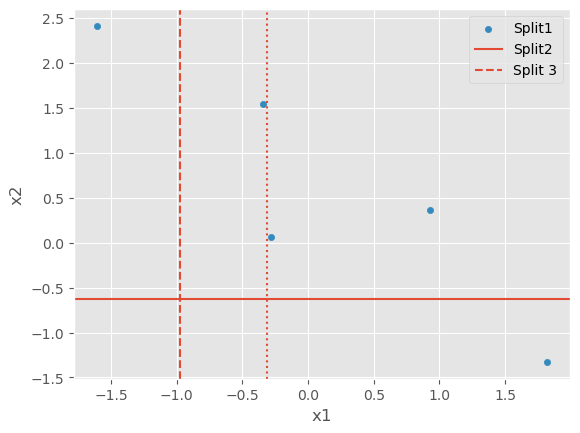

In [97]:
# using ax we continue editing the above plot
if splitVar==1:
    ax.axvline(x=splitLevel_3,linestyle=':')
else:
    ax.axhline(y=splitLevel_3,linestyle=':')
ax.legend(['Split1','Split2','Split 3'],bbox_to_anchor=(1, 1))
ax.get_figure()

In [98]:
[np.mean(r.y) for r in [Reg1,Reg2,Reg3,Reg4,Reg5,Reg6]]

[np.float64(-4.1608770553392915),
 np.float64(9.03397249583563),
 np.float64(-1.893722409511722),
 np.float64(-10.962340992822),
 np.float64(-0.389293988930543),
 np.float64(-4.90257925067408)]

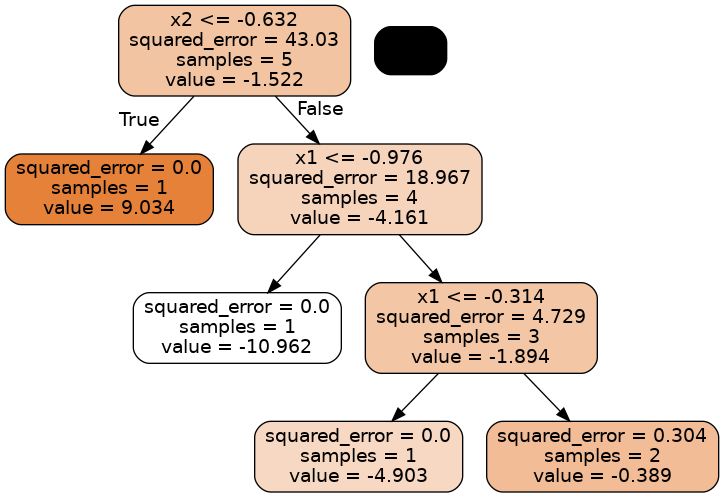

In [100]:
built_tree = DecisionTreeRegressor(random_state=0,max_leaf_nodes=4)
built_tree.fit(tree_data.drop('y',axis=1),tree_data.y)
plot_tree(built_tree,['x1','x2'])